# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook two - Labeling of the data

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

This notebook is based on De Prado, "Advances in Financial Machine Learning" book. Here we implement the tripple-barrier labeling technique, where the return either hits one of the horizontal barriers (take profit/stop loss) or a vertical barrier (maximum holding period.

In [2]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..') # r'C:\WQU\Capstone\Working_files'
sys.path.append(path_to_project)

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from multiprocessing import cpu_count

In [4]:
import warnings
warnings.filterwarnings('ignore')

We packed the main part of the code into a library below for this project.

In [5]:
from WQUcapstoneCode.sampling import sampling
from WQUcapstoneCode.labeling import labeling

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

Prepare the data

In [10]:
ticker = 'AUD/USD'
input_path = os.path.join(path_to_project, 'input_data', ''.join(ticker.split('/')) + '.csv')
pair = pd.read_csv(input_path)
pair.index =[dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in pair.date]
pair = pair.drop(columns=['date'])


ticks_multiplier = 2. 

m_ticks = ticks_multiplier * pair.tickqty.sum()/pair.shape[0] # average number of ticks in 4 hour interval

tick_df = sampling.sampled_bar_df(pair, 'tickqty',m_ticks)


100%|██████████| 19050/19050 [00:00<00:00, 385660.32it/s]


Daily volatility is calculated as exponentially weighted standard deviation over certain time span

In [13]:
close = tick_df.bidclose.copy()   #close price 
dailyVol = labeling.getDailyVol(close) #daily volatility


Let's plot the average daily volatility

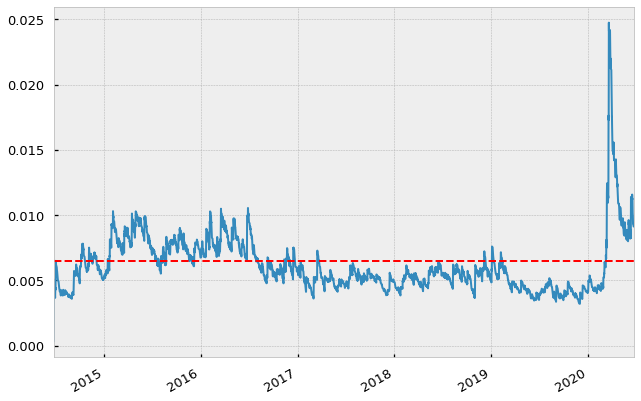

In [14]:
f,ax=plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(),ls='--',color='r')

In [17]:
#getting bid and ask prices

close = tick_df[['bidclose','askclose']]
close.columns = ['bid','ask']

The symmetric CUSUM filter is designed to detect a shift in the mean value of a measured quantity away from a target value.
Please note that the below function from the book was adapted to incorporate bid-ask spreads (instead of close price).
We may add a vertical barrier (max holding period) to our event sample as well. Here we assume that we don't want to hold the position for more than 3 days.

In [18]:
tEvents = labeling.getTEvents(close,h=dailyVol.mean()) #events when upper or lower barrier was reached
t1 = labeling.addVerticalBarrier(tEvents, close, numDays=3) #The third barrier is defined in terms of number of bars elapsed since the position was taken (an expiration limit).

100%|██████████| 7117/7117 [00:01<00:00, 6098.22it/s]


Below are begining and end(time barrier) for all events.

In [21]:
t1

2014-06-25 05:00:00   2014-06-29 23:00:00
2014-06-26 23:00:00   2014-06-29 23:00:00
2014-07-01 13:00:00   2014-07-04 17:00:00
2014-07-03 01:00:00   2014-07-07 05:00:00
2014-07-08 15:00:00   2014-07-13 21:00:00
2014-07-16 05:00:00   2014-07-21 03:00:00
2014-07-23 01:00:00   2014-07-27 21:00:00
2014-07-29 15:00:00   2014-08-01 15:00:00
2014-07-30 15:00:00   2014-08-04 01:00:00
2014-08-06 19:00:00   2014-08-10 21:00:00
2014-08-07 03:00:00   2014-08-10 21:00:00
2014-08-13 13:00:00   2014-08-18 07:00:00
2014-08-21 01:00:00   2014-08-24 21:00:00
2014-08-22 05:00:00   2014-08-25 05:00:00
2014-08-28 01:00:00   2014-08-31 23:00:00
2014-09-02 05:00:00   2014-09-05 07:00:00
2014-09-03 15:00:00   2014-09-07 23:00:00
2014-09-08 19:00:00   2014-09-11 23:00:00
2014-09-09 13:00:00   2014-09-12 15:00:00
2014-09-10 07:00:00   2014-09-14 23:00:00
2014-09-11 15:00:00   2014-09-14 23:00:00
2014-09-14 23:00:00   2014-09-18 03:00:00
2014-09-16 15:00:00   2014-09-19 15:00:00
2014-09-17 17:00:00   2014-09-22 0

Plotting the last 50 events

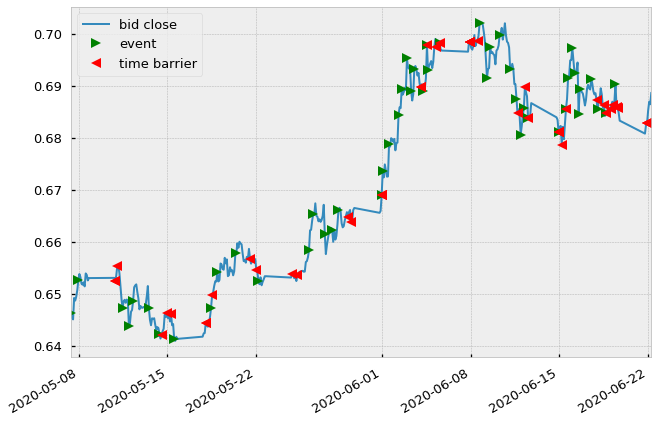

In [22]:
from_event = -51
to_event = from_event + 50
close_subset = pair[(pair.index>=tEvents[from_event]) & (pair.index<=tEvents[to_event])]
f,ax=plt.subplots()
close_subset.bidclose.plot(ax=ax, label='bid close')
ax.plot(close_subset.bidclose[t1[from_event:to_event].index], ls='', marker='>', color='g', label = 'event')
ax.plot(close_subset.bidclose[t1[from_event:to_event].values], ls='',marker='<', color='r', label = 'time barrier')
ax.legend()

Now we can generate labels for our events

In [23]:
ptsl = [1, 1] #symmetric take-profit and stop-loss
target = dailyVol
# select minRet
minRet = dailyVol.mean()*0.7
close = (close['bid'] + close['ask']) / 2 #to simplify we'll work with the mid price

In [24]:
#we use multiprocessing, but for debugging you may choose to run 1 process
testMode = False
cpus = 1 if testMode else cpu_count() - 1

In [27]:
events = labeling.getEvents(close, tEvents, ptsl, target, minRet, cpus, t1=t1)
#print(events)


                                     t1      trgt
2014-06-26 23:00:00 2014-06-29 23:00:00  0.004909
2014-07-03 01:00:00 2014-07-07 05:00:00  0.005489
2014-07-08 15:00:00 2014-07-13 21:00:00  0.005711
2014-09-09 13:00:00 2014-09-10 01:00:00  0.005040
2014-09-10 07:00:00 2014-09-11 01:00:00  0.005669
2014-09-11 15:00:00 2014-09-12 11:00:00  0.005504
2014-09-14 23:00:00 2014-09-16 15:00:00  0.005579
2014-09-16 15:00:00 2014-09-17 17:00:00  0.005474
2014-09-17 17:00:00 2014-09-17 21:00:00  0.005747
2014-09-17 21:00:00 2014-09-22 01:00:00  0.006051
2014-09-22 07:00:00 2014-09-25 05:00:00  0.005920
2014-09-23 15:00:00 2014-09-25 17:00:00  0.005670
2014-09-25 05:00:00 2014-09-28 23:00:00  0.005411
2014-09-28 23:00:00 2014-10-01 03:00:00  0.005238
2014-09-30 03:00:00 2014-10-01 03:00:00  0.005055
2014-10-01 03:00:00 2014-10-01 07:00:00  0.004961
2014-10-01 17:00:00 2014-10-02 03:00:00  0.004787
2014-10-02 03:00:00 2014-10-03 11:00:00  0.005012
2014-10-03 11:00:00 2014-10-03 13:00:00  0.005929


2020-06-28 21:48:02.511290 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes.


In [16]:
labels = labeling.getBins(events, close)
labels = labeling.dropLabels(labels)
labels.bin.value_counts()

-1.0    353
 1.0    319
 0.0    308
Name: bin, dtype: int64

In [17]:
labels

,ret,bin
2014-06-26 23:00:00,-0.000111,0.0
2014-07-03 01:00:00,-0.002074,0.0
2014-07-08 15:00:00,-0.001458,0.0
2014-09-09 13:00:00,-0.006074,-1.0
2014-09-10 07:00:00,0.006435,1.0
...,...,...
2020-06-17 13:00:00,-0.011326,-1.0
2020-06-18 01:00:00,-0.003946,0.0
2020-06-18 17:00:00,-0.002673,0.0
2020-06-19 11:00:00,-0.009972,-1.0


### Conclusion

As a result of this exercise, we generated labels based on triple-barrier method as in De Prado, "Advances in Financial Machine Learning" book. We improved some functions, specifically, we calculate events taking into account bid-ask spread. In addition, our labels are not binary. Instead, there are 3 types of labels. 
Going forward, we will use these labels to teach the machine learning model the side of the trade. After that, we're going to use meta-labeling to buld another model on top of it - to learn the size of a bet.